In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import os

%matplotlib inline

In [2]:
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [3]:
card_id = 100
slot_id = 24
channel_id = 11

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [4]:
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]  # shape: (n_events, n_bins)

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

print("Loaded signal waveforms:", signal_waveforms.shape)
print("Loaded control waveforms:", control_waveforms.shape)

Loaded signal waveforms: (10000, 64)
Loaded control waveforms: (10000, 64)


In [5]:
def compute_charges(waveforms, integration_range=None):
    """
    Calcula la carga integrada de cada waveform.
    waveforms: (n_events, n_bins)
    integration_range: tuple (lo, hi) en bins. Si None, usa toda la waveform.
    """
    if integration_range is None:
        return waveforms.sum(axis=1)
    lo, hi = integration_range
    return waveforms[:, lo:hi].sum(axis=1)

# --- calcular cargas ---
signal_charges = compute_charges(signal_waveforms)
control_charges = compute_charges(control_waveforms)

print("Signal charges:", signal_charges.shape)
print("Control charges:", control_charges.shape)

# --- plots comparativos ---
plt.figure(figsize=(7,4.5))
bins = np.linspace(
    min(control_charges.min(), signal_charges.min()),
    max(control_charges.max(), signal_charges.max()),
    120
)

Signal charges: (10000,)
Control charges: (10000,)


<Figure size 700x450 with 0 Axes>

Eso que comentas indica que ahora lo que has calculado (signal_charges, control_charges) ya no son waveforms, sino los valores integrados de carga por cada waveform.

Te explico:

Antes (signal_waveforms.shape = (10000, 64)):
→ 10 000 waveforms (triggers) × 64 samples cada una.

Después de aplicar compute_charges(...):
→ signal_charges.shape = (10000,) porque hemos colapsado los 64 samples en un único número (la carga integrada de cada waveform).

Esto es totalmente esperado.
Ya no tenemos la forma temporal de cada pulso, sino un histograma de cargas integradas → eso es justo lo que quieres para ver el pedestal vs s.p.e.

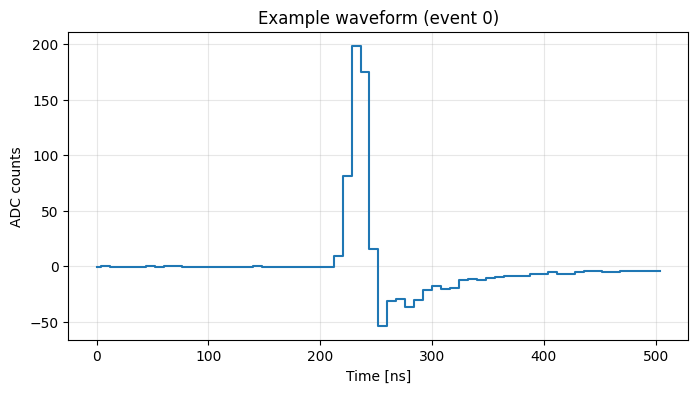

Integrated charge for event 0: 55.40 ADC·counts


In [6]:
# Selecciona un evento cualquiera
i = 0  
wf = signal_waveforms[i]

plt.figure(figsize=(8,4))
plt.plot(np.arange(64)*8, wf, drawstyle="steps-mid")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.grid(alpha=0.3)
plt.show()

# Calcular la carga de esta waveform
charge = np.sum(wf)
print(f"Integrated charge for event {i}: {charge:.2f} ADC·counts")

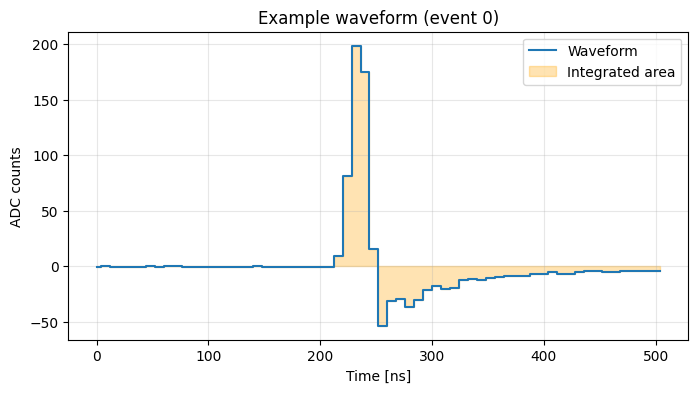

Integrated charge for event 0: 443.20 ADC·ns


In [7]:
# Selecciona un evento cualquiera
i = 0  
wf = signal_waveforms[i]

# Eje de tiempos (64 samples * 8 ns)
time_axis = np.arange(64) * 8  

# Calcular la carga: sumatoria de wf * 8 ns
charge = np.sum(wf) * 8  

plt.figure(figsize=(8,4))
plt.plot(time_axis, wf, drawstyle="steps-mid", label="Waveform")
plt.fill_between(time_axis, wf, step="mid", alpha=0.3, color="orange", label="Integrated area")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Integrated charge for event {i}: {charge:.2f} ADC·ns")   # x8 ns porque cada sample (64 per waveform) es de 8ns

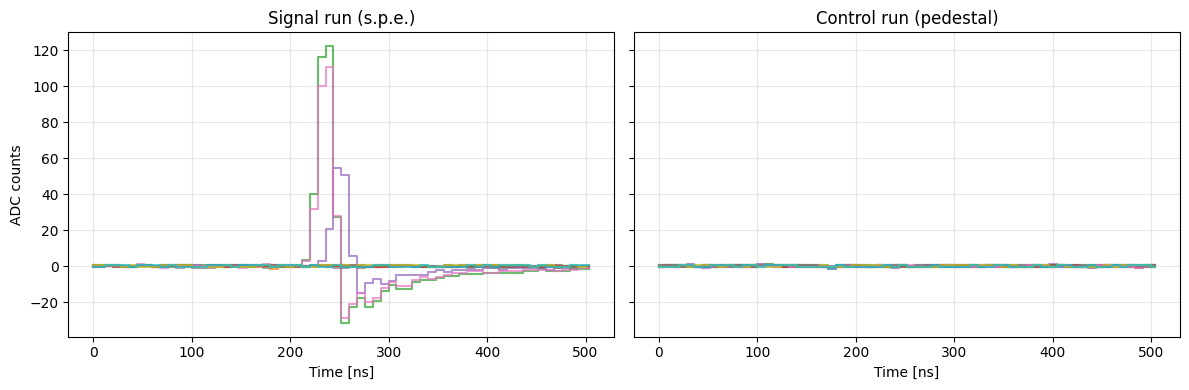

In [8]:
def plot_random_waveforms(signal_waveforms, control_waveforms, n_events=5):
    # elegir índices aleatorios
    sig_idx = np.random.choice(signal_waveforms.shape[0], n_events, replace=False)
    ctrl_idx = np.random.choice(control_waveforms.shape[0], n_events, replace=False)

    time = np.arange(signal_waveforms.shape[1]) * 8  #cada sample = 8 ns

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --------singal----------
    for i in sig_idx:
        wf = signal_waveforms[i]
        axes[0].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[0].set_title("Signal run (s.p.e.)")
    axes[0].set_xlabel("Time [ns]")
    axes[0].set_ylabel("ADC counts")
    axes[0].grid(alpha=0.3)

    # ------control----------
    for i in ctrl_idx:
        wf = control_waveforms[i]
        axes[1].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[1].set_title("Control run (pedestal)")
    axes[1].set_xlabel("Time [ns]")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_random_waveforms(signal_waveforms, control_waveforms, n_events=10)

En la señal (LED, s.p.e.) → picos muy claros centrados en cierto rango (~200 ns). Eso son tus pulsos de fotoelectrones.

En el control (pedestal) → solo ruido alrededor de cero (sin pulsos). Eso es lo esperado: el trigger se disparó pero sin LED, por lo que solo mides la base electrónica.

In [70]:
from matplotlib.lines import Line2D

# --- PMT to test ---
card_id = 100
slot_id = 24
channel_id = 8
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz  = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"

bin_width = 8.0  # ns per bin

# --- Functions ---
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

# --- Load waveforms ---
signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

# --- Pick first valid waveform above fixed threshold ---
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

if len(valid_indices) == 0:
    raise RuntimeError(f"No waveform above threshold {threshold} found for {pmt_label}")

wf_index = valid_indices[10]
wf = signal_waveforms[wf_index]
peak_idx = int(np.argmax(wf))
n_samples = len(wf)
time_axis = np.arange(n_samples) * bin_width

print(f"Using waveform index {wf_index}, peak at bin {peak_idx}")
print(f"Threshold used: {threshold} ADC counts")

# --- Generate windows systematically: 4, 5, 6, 7, 8 bins ---
bin_sizes = [4, 5, 6, 7, 8]
all_windows = []

for n_bins in bin_sizes:
    for pre in range(1, n_bins):
        post = n_bins - pre - 1
        if post >= 1 and pre != post:  # discard symmetric and ensure pre<0, post>0
            if pre !=1 and post <=4:
                all_windows.append((-pre, post))

# --- Compute Q and noise for the selected waveform only ---
results = []
for w in all_windows:
    pre_peak = -w[0]
    post_peak = w[1]

    # define integration limits for this waveform
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    N = end - start

    # --- Q (integrated charge for this waveform) ---
    Q = np.sum(wf[start:end]) * bin_width

    # --- Noise (baseline fluctuation propagated) ---
    sigma_bin = np.std(wf[:10])  # baseline RMS
    sigma_Q = np.sqrt(N) * sigma_bin * bin_width

    # --- Relative error (%) ---
    rel_err = (sigma_Q / Q) * 100 if Q != 0 else np.nan

    results.append({
        'window': w,
        'n_bins': N,
        'Q': Q,
        'noise': sigma_Q,
        'rel_error(%)': rel_err,
        'start': start,
        'end': end
    })

# --- Print table ---
print("\nResults per window (non-symmetric only):")
print(f"{'window':12s} {'bins':>5s} {'Q [ADC·ns]':>18s} {'σ_Q [ADC·ns]':>12s} {'rel_err [%]':>12s}")


results_sorted_final = sorted(results, key=lambda r: (r['n_bins'], -r['Q']))

best_candidates = results_sorted_final[:3]  # top 3 by this sorting

for r in results_sorted_final:
    print(f"[{r['window'][0]},{r['window'][1]}] {r['n_bins']:5d} "
          f"{r['Q']:18.1f} {r['noise']:12.1f} {r['rel_error(%)']:12.2f}")

print("\nBest candidate integration windows")
for r in best_candidates:
    print(f"Window {r['window']}, bins={r['n_bins']}, "
          f"Q={r['Q']:.1f}, σ_Q={r['noise']:.1f}, rel_err={r['rel_error(%)']:.2f}%")


Using waveform index 49, peak at bin 30
Threshold used: 50 ADC counts

Results per window (non-symmetric only):
window        bins         Q [ADC·ns] σ_Q [ADC·ns]  rel_err [%]
[-2,1]     4             1028.8          4.8         0.47
[-3,1]     5             1036.0          5.4         0.52
[-4,1]     6             1035.2          5.9         0.57
[-3,2]     6              931.2          5.9         0.63
[-2,3]     6              835.2          5.9         0.70
[-5,1]     7             1034.4          6.3         0.61
[-4,2]     7              930.4          6.3         0.68
[-2,4]     7              786.4          6.3         0.81
[-6,1]     8             1041.6          6.8         0.65
[-5,2]     8              929.6          6.8         0.73
[-4,3]     8              841.6          6.8         0.81
[-3,4]     8              793.6          6.8         0.86

Best candidate integration windows
Window (-2, 1), bins=4, Q=1028.8, σ_Q=4.8, rel_err=0.47%
Window (-3, 1), bins=5, Q=1036.0, σ

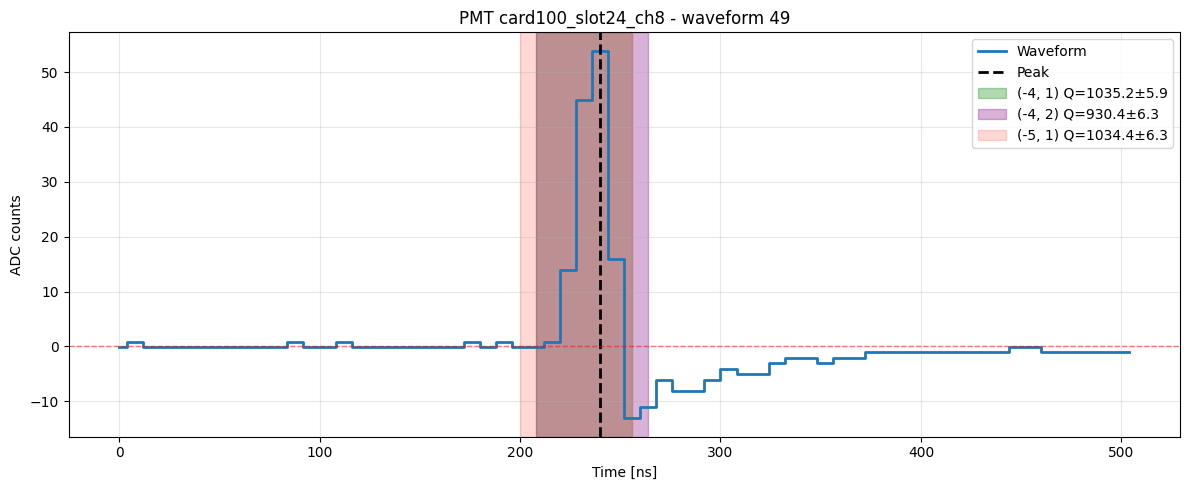

In [71]:
candidate_windows = [(-4,2), (-5,1), (-4,1)]


results_candidates = [r for r in results if r['window'] in candidate_windows]

plt.figure(figsize=(12,5))
plt.plot(time_axis, wf, drawstyle="steps-mid", lw=2, label=f"Waveform")
plt.axvline(peak_idx*bin_width, color='k', ls='--', lw=2, label='Peak')


color_map_fixed = {
    (-4,2): 'purple',
    (-5,1): 'salmon',   
    (-4,1): 'green'
}

for r in results_candidates:
    xs = time_axis[r['start']]
    xe = time_axis[r['end']-1] + bin_width
    plt.axvspan(xs, xe, alpha=0.3, color=color_map_fixed[r['window']], 
                label=f"{r['window']} Q={r['Q']:.1f}±{r['noise']:.1f}")
    plt.axhline(0, color="red", linestyle = "--", lw=1, alpha=0.2)

plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"PMT {pmt_label} - waveform {wf_index}")
plt.legend(fontsize=10, ncol=1, frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Number of windows after filtering: 9


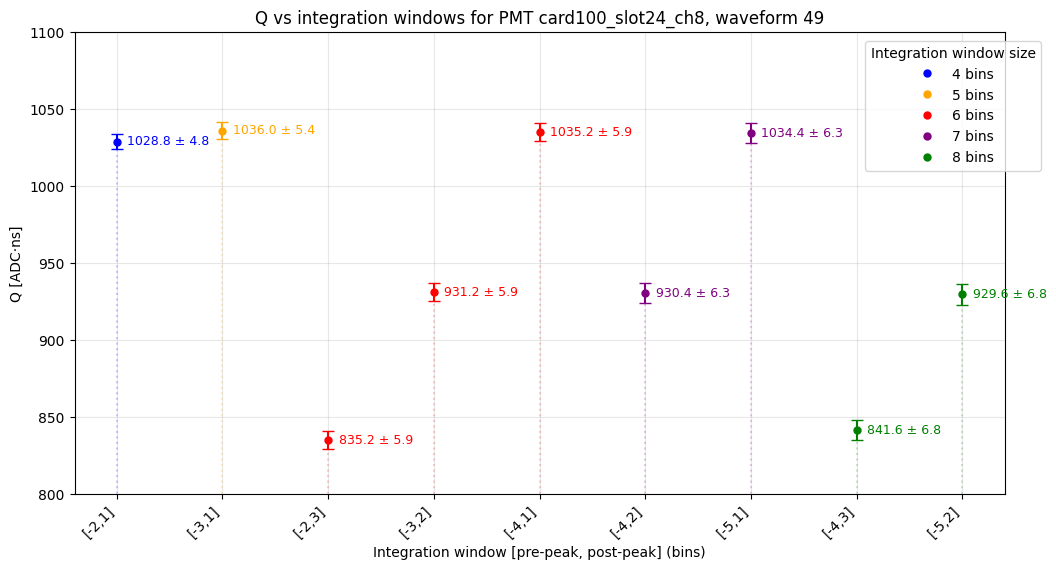

In [86]:
candidate_windows = [(-4,2), (-5,1), (-4,1)]
extra_bins = [4, 5, 6, 7, 8] 


plot_results = []
for r in results:
    pre, post = r['window']
    if pre in (-1,-6):
        continue  # discard pre=-1
    if post in (4, 5):
        continue  # discard post=+4 or +5
    if r['window'] in candidate_windows or r['n_bins'] in extra_bins:
        plot_results.append(r)


print("Number of windows after filtering:", len(plot_results))


color_map_bins = {
    4: 'blue',
    5: 'orange',
    6: 'red',
    7: 'purple',
    8: 'green'
}


#scatter plot
plt.figure(figsize=(12,6))

#convert integration windows to strings for x-axis
x_labels = [f"[{w[0]},{w[1]}]" for w in [r['window'] for r in plot_results]]

#numeric positions for plotting
x_pos = range(len(plot_results))

for i, r in enumerate(plot_results):
    w = r['window']
    Q = r['Q']
    sigma_Q = r['noise']
    n_bins = r['n_bins']
    color = color_map_bins[n_bins]


    plt.errorbar(
        x_pos[i], Q, yerr=sigma_Q,
        fmt='o', color=color,
        markersize=5, capsize=4
    )

    # vertical lines
    plt.vlines(
        x=x_pos[i], ymin=0, ymax=Q,
        colors=color, linestyles="dotted", alpha=0.2
    )

    #text Q ± sigma_Q
    plt.text(
        x_pos[i] + 0.1, Q,
        f"{Q:.1f} ± {sigma_Q:.1f}",
        color=color,
        fontsize=9,
        va='center'
    )

#set categorical labels
plt.xticks(x_pos, x_labels, rotation=45, ha='right')

#legend
custom_lines = [Line2D([0], [0], color=color_map_bins[b], marker='o', lw=0, markersize=5, label=f"{b} bins")
                for b in sorted(color_map_bins.keys())]

plt.legend(handles=custom_lines, title="Integration window size", fontsize=10, loc=(0.85,0.7))
plt.xlabel("Integration window [pre-peak, post-peak] (bins)")
plt.ylabel("Q [ADC·ns]")
plt.title(f"Q vs integration windows for PMT {pmt_label}, waveform {wf_index}")
plt.grid(alpha=0.3)
#plt.tight_layout()
plt.ylim(800,1100)
plt.show()

In [103]:
from tqdm import tqdm
from collections import defaultdict

integration_windows = [(-4, 2), (-5, 1), (-4, 1), (-2,1), (-3,1)]

# Store results per PMT
results_all_pmts = {w: [] for w in integration_windows}

bin_width = 8.0  # ns per bin
threshold = 50   # ADC counts

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

def window_noise(wf, start, end):
    """Compute RMS of waveform in given window (represents noise contribution)."""
    return np.sqrt(np.mean(wf[start:end]**2))

# --- Loop over PMTs present in signal_pmts only with progress bar ---
total_pmts = len(signal_pmts)
print(f"Processing {total_pmts} PMTs from signal...")

for pmt_id in tqdm(signal_pmts, desc="Processing PMTs"):
    # parse card, slot, channel
    parts = pmt_id.replace("card", "").replace("slot", "").replace("ch", "").split("_")
    card_id, slot_id, channel_id = map(int, parts)
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

    # load waveforms
    try:
        signal_waveforms = load_waveforms(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
    except FileNotFoundError:
        print(f"Warning: waveform file not found for {pmt_label}, skipping.")
        continue

    # select valid waveforms above threshold
    valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]
    if not valid_indices:
        continue  # skip PMT if no waveform above threshold

    # loop over candidate windows
    for window in integration_windows:
        pre_peak = -window[0]
        post_peak = window[1]

        Qs = []
        sigmas = []
        for wf_idx in valid_indices:
            wf_evt = signal_waveforms[wf_idx]
            peak_idx_evt = np.argmax(wf_evt)
            start = max(0, peak_idx_evt - pre_peak)
            end   = min(len(wf_evt), peak_idx_evt + post_peak + 1)
            N = end - start

            # Integrated charge
            Q = np.sum(wf_evt[start:end]) * bin_width

            # Noise contribution
            sigma_bin = np.std(wf_evt[:10])  # baseline RMS
            sigma_Q = np.sqrt(N) * sigma_bin * bin_width

            Qs.append(Q)
            sigmas.append(sigma_Q)

        Qs = np.array(Qs)
        sigmas = np.array(sigmas)

        # store per PMT: average Q, average sigma_Q, S/N (Q/sigma)
        avg_Q = np.mean(Qs)
        avg_sigma = np.mean(sigmas)
        sn_ratio = avg_Q / avg_sigma if avg_sigma != 0 else np.nan

        results_all_pmts[window].append({
            'pmt': pmt_label,
            'avg_Q': avg_Q,
            'avg_sigma': avg_sigma,
            'S_over_N': sn_ratio
        })

# --- Compute overall Q, sigma_Q and S/N across all PMTs ---
summary_results = []
for window, res_list in results_all_pmts.items():
    avg_Q_all = np.mean([r['avg_Q'] for r in res_list])
    avg_sigma_all = np.mean([r['avg_sigma'] for r in res_list])
    avg_sn_all = np.mean([r['S_over_N'] for r in res_list])
    summary_results.append({
        'window': window,
        'avg_Q': avg_Q_all,
        'avg_sigma': avg_sigma_all,
        'avg_SNR': avg_sn_all
    })

# --- Sort by Q descending, then sigma ascending (prioritize signal vs noise) ---
summary_sorted = sorted(summary_results, key=lambda r: (-r['avg_Q'], r['avg_sigma']))

# --- Print results ---
print("\nSummary of candidate integration windows across all PMTs:")
print(f"{'window':12s} {'avg_Q [ADC·ns]':>15s} {'avg_sigma_Q':>15s} {'avg S/N':>10s}")
for r in summary_sorted:
    w = r['window']
    print(f"[{w[0]},{w[1]}] {r['avg_Q']:15.1f} {r['avg_sigma']:15.1f} {r['avg_SNR']:10.2f}")

# --- Best two integration windows ---
best_two = summary_sorted[:2]
print("\nTwo best integration windows (max Q, min sigma_Q):")
for r in best_two:
    w = r['window']
    print(f"Window {w}: avg_Q = {r['avg_Q']:.1f}, avg_sigma_Q = {r['avg_sigma']:.1f}, avg_S/N = {r['avg_SNR']:.2f}")


Processing 1548 PMTs from signal...


Processing PMTs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1548/1548 [14:52<00:00,  1.73it/s]


Summary of candidate integration windows across all PMTs:
window        avg_Q [ADC·ns]     avg_sigma_Q    avg S/N
[-4,1]          1511.1             8.1     193.53
[-5,1]          1511.0             8.7     179.30
[-3,1]          1510.3             7.4     211.77
[-2,1]          1502.1             6.6     235.37
[-4,2]          1453.5             8.7     172.28

Two best integration windows (max Q, min sigma_Q):
Window (-4, 1): avg_Q = 1511.1, avg_sigma_Q = 8.1, avg_S/N = 193.53
Window (-5, 1): avg_Q = 1511.0, avg_sigma_Q = 8.7, avg_S/N = 179.30


S/N = Signal/Noise i.e. Q/sigma_Q. 

avg_S/N se calcula promediando esos valores sobre todas las waveforms y PMTs. Cuanto mayor sea avg_S/N, más limpia es la señas edntro de esa ventana (mucha señal, poco ruido)

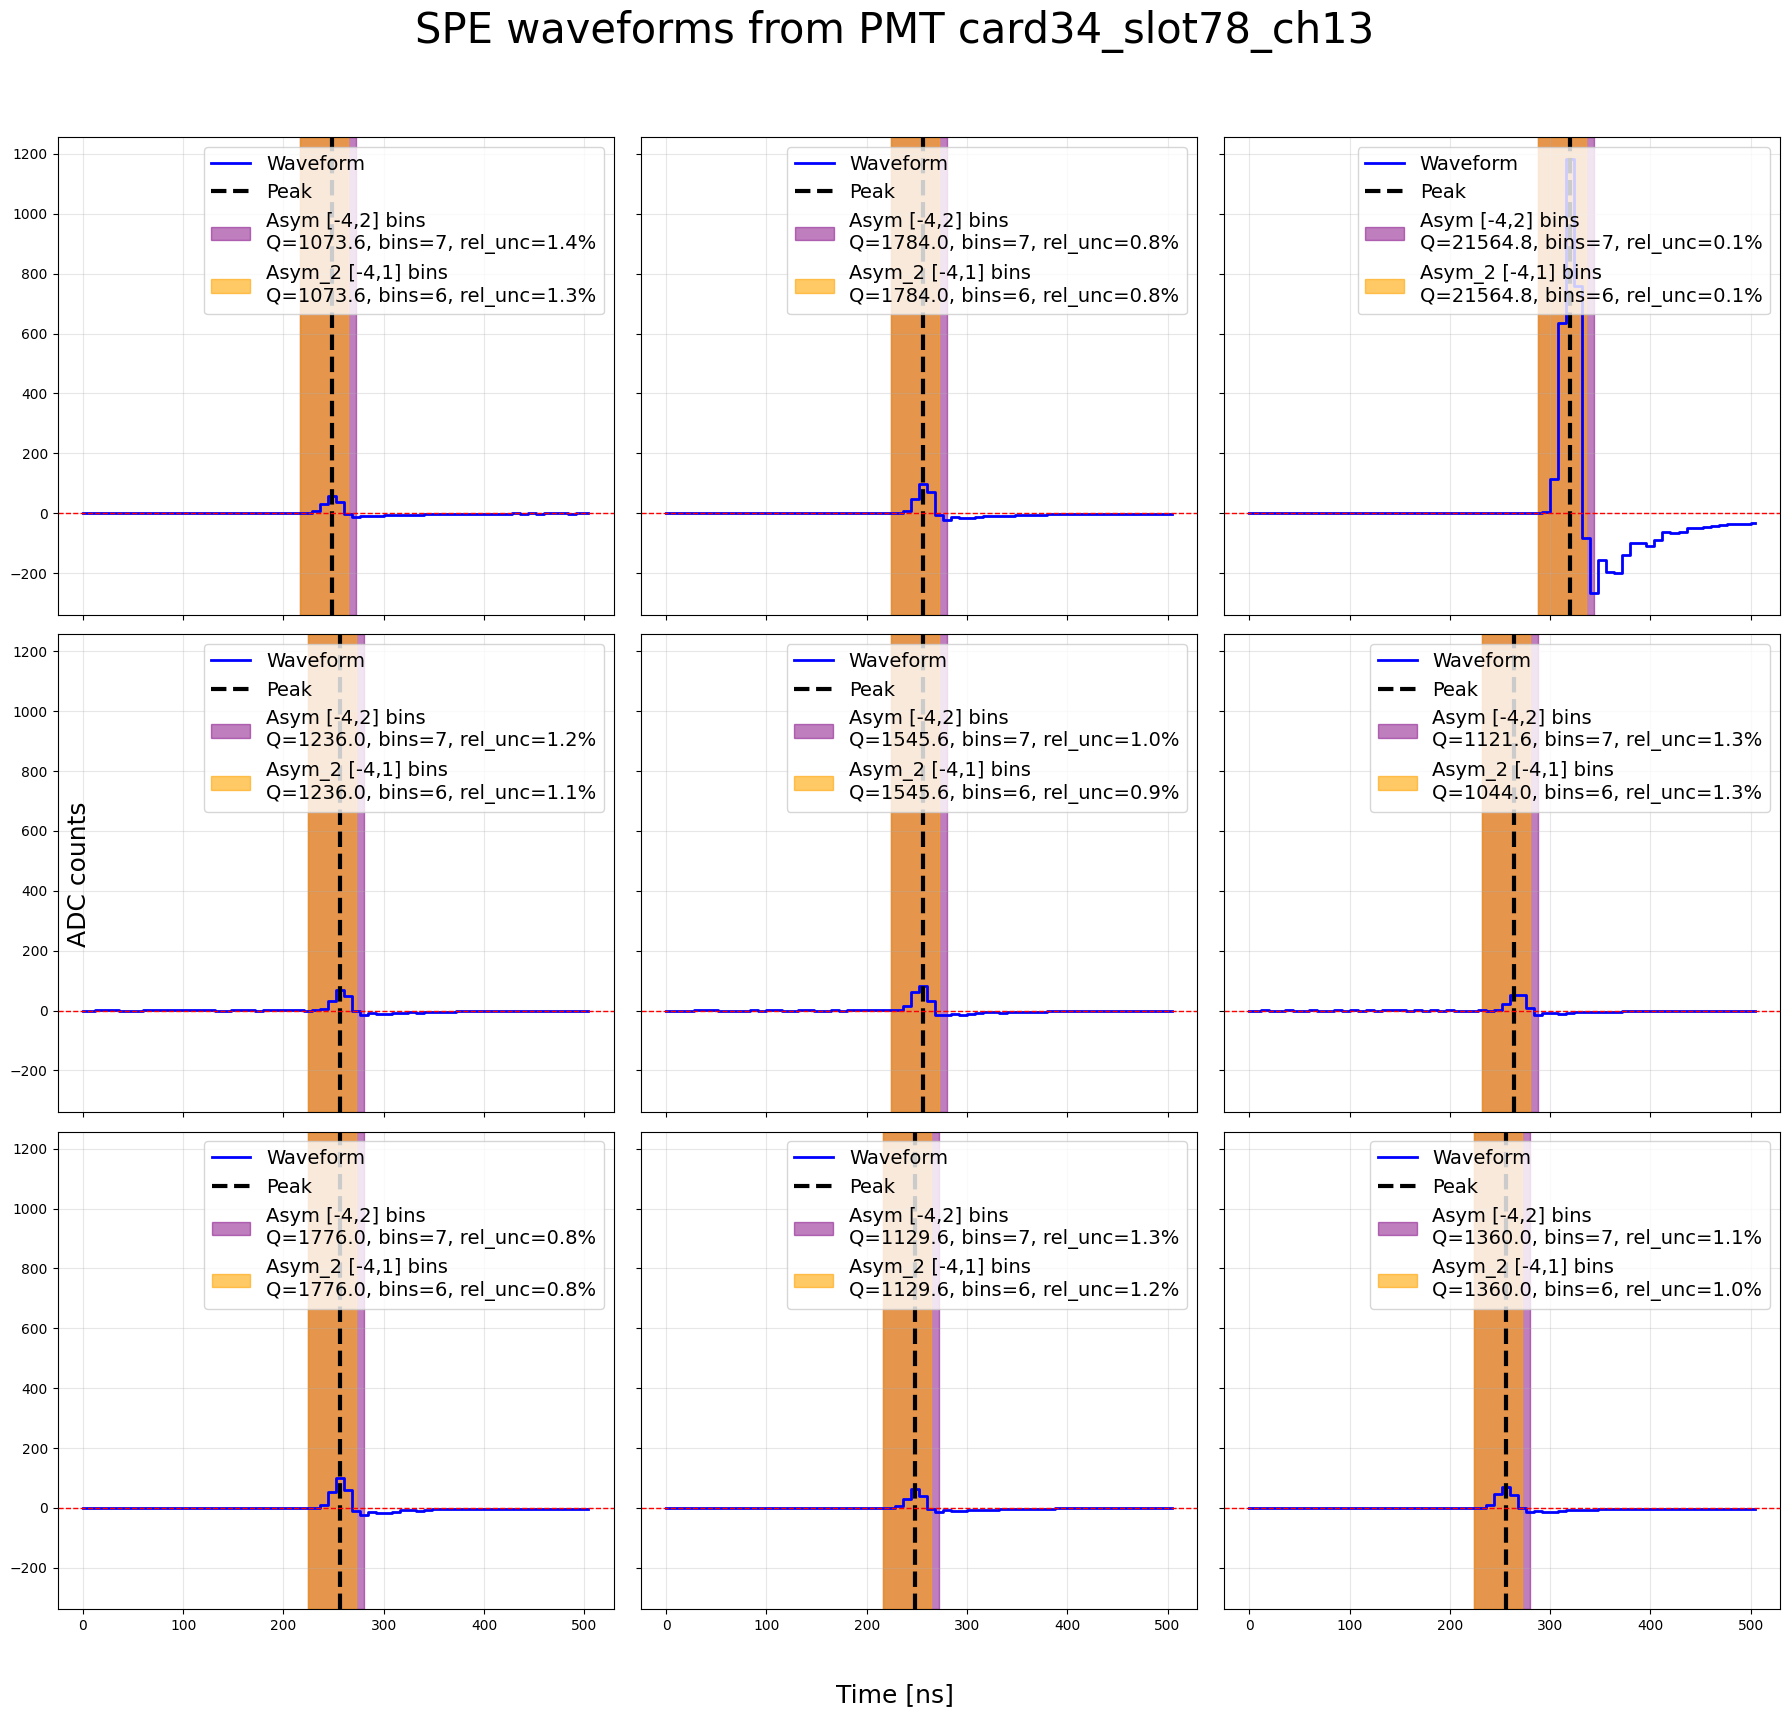

In [14]:
card_id = 34
slot_id = 78
channel_id = 13

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

bin_width = 8.0  # 8 ns per sample/bin

# Load waveforms
signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
asym_window_2 = (-4, +1)    

# Noise estimation (from pedestal run or RMS of baseline in signal run)
sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

#chose random waveforms!
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Asymmetric window 2 (optional)
    start_asym_2 = max(0, peak_idx + asym_window_2[0])
    end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    bins_asym_2 = end_asym_2 - start_asym_2
    Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=3, label="Peak")
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.5, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    ax.axhline(0, color="red", linestyle = "--", lw=1)
    
    ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
               alpha=0.6, color="orange", label=(
                   f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
                   f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=14, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=18)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=18)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=30)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

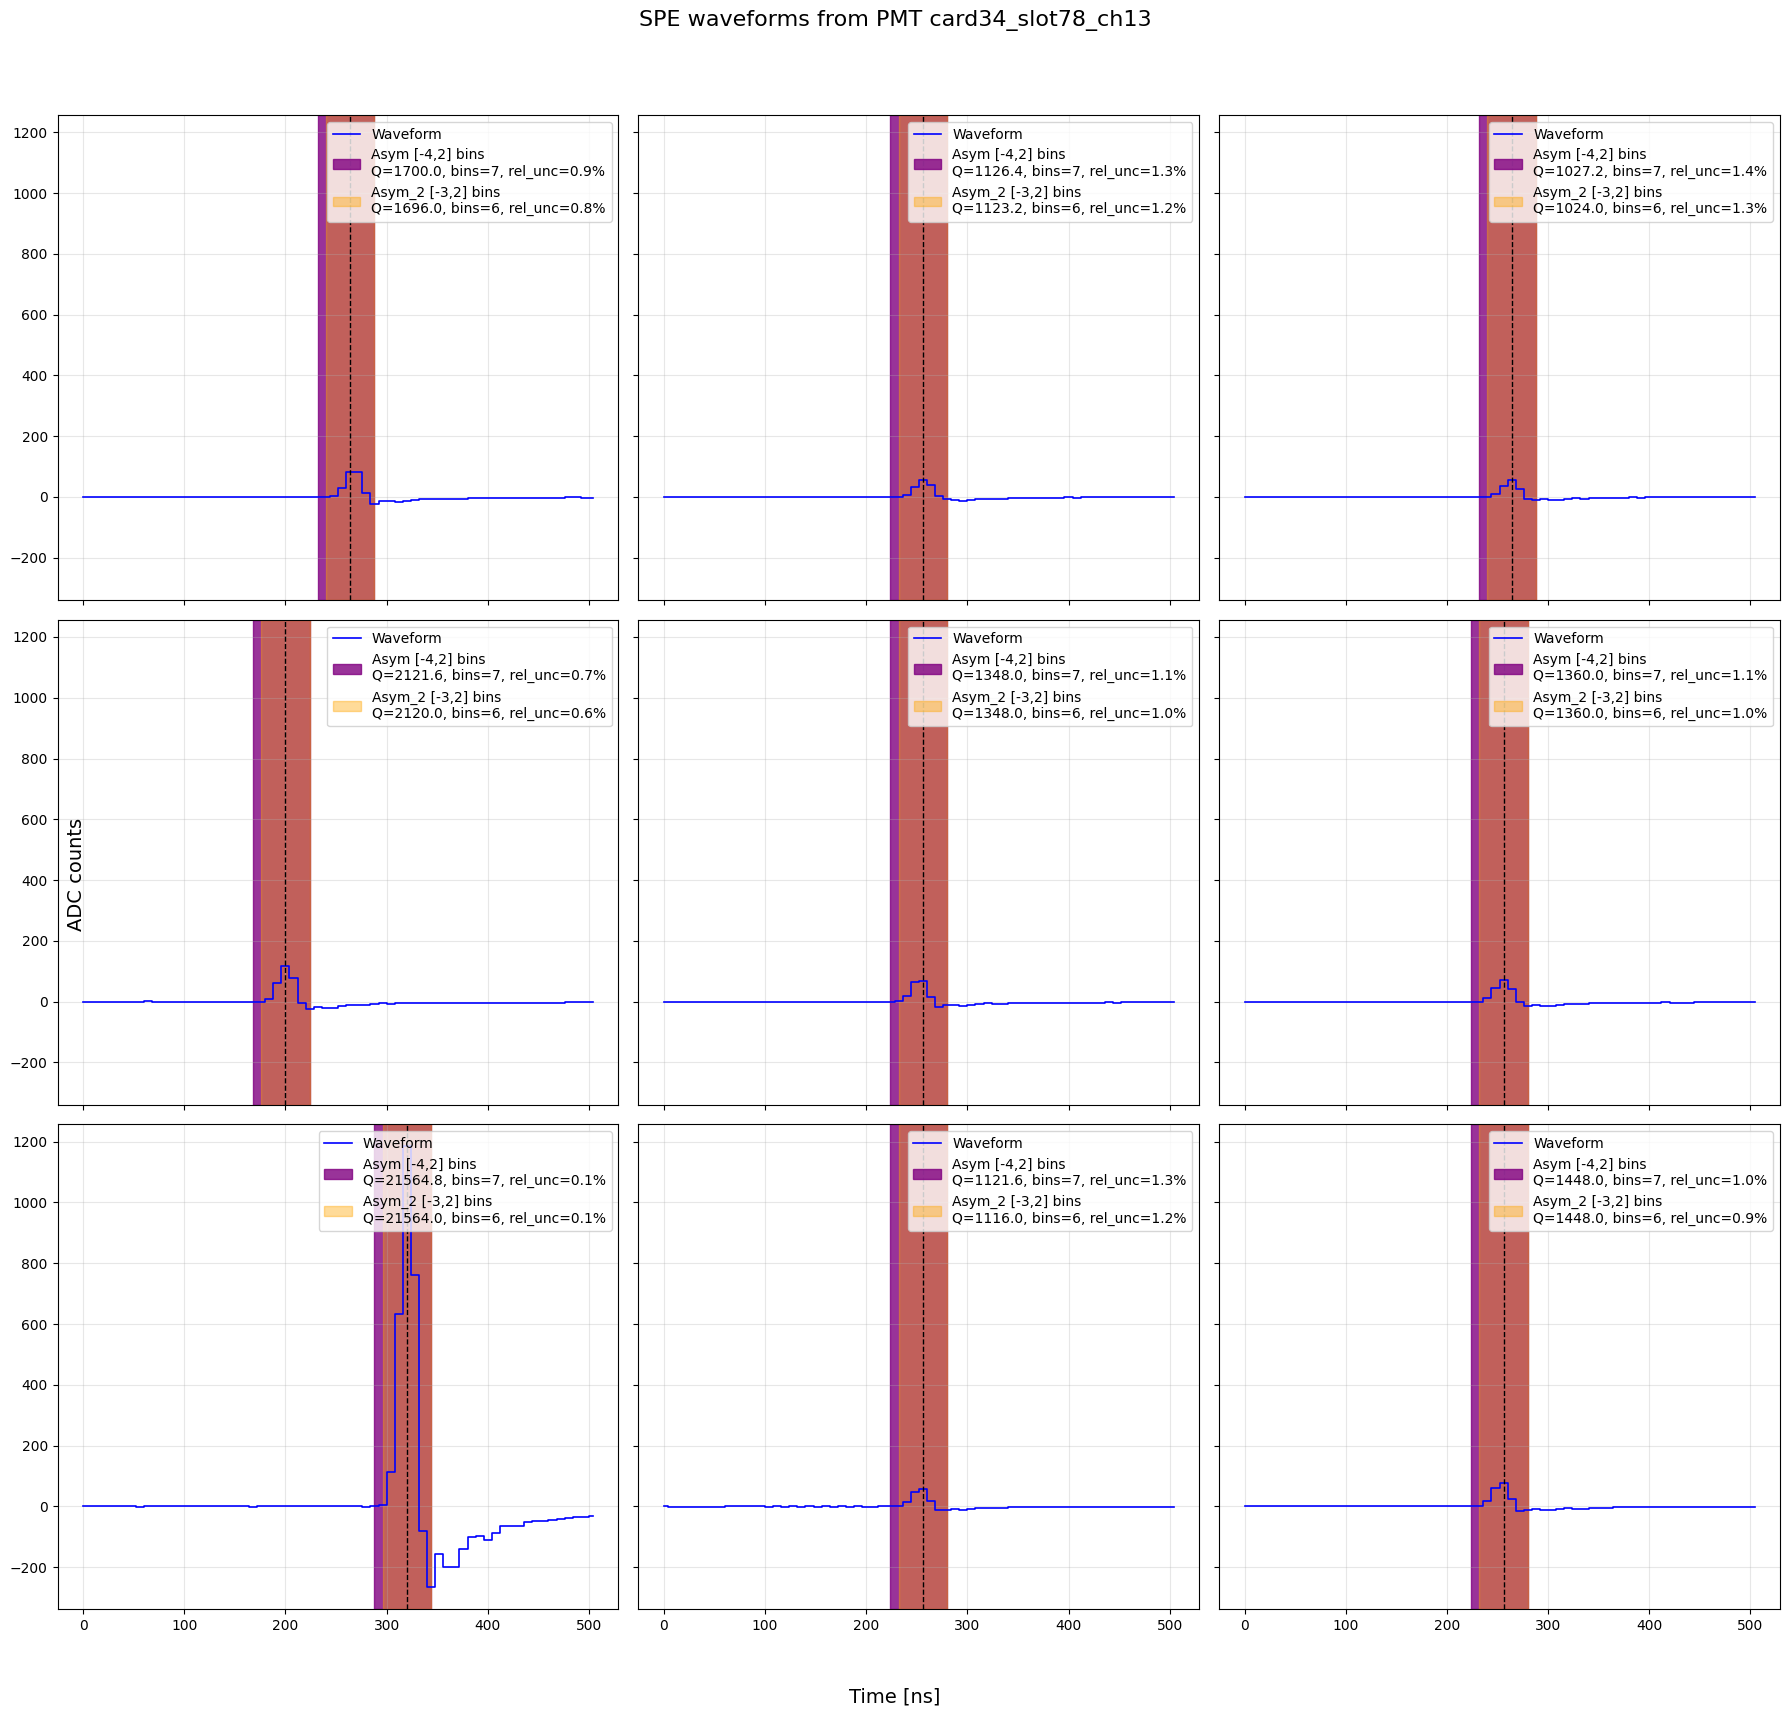

In [15]:
import numpy as np
import matplotlib.pyplot as plt

bin_width = 8.0  # 8 ns per sample/bin


signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
asym_window_2 = (-3, +2)    


sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]


indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Asymmetric window 2 
    start_asym_2 = max(0, peak_idx + asym_window_2[0])
    end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    bins_asym_2 = end_asym_2 - start_asym_2
    Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
               alpha=0.4, color="orange", label=(
                   f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
                   f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

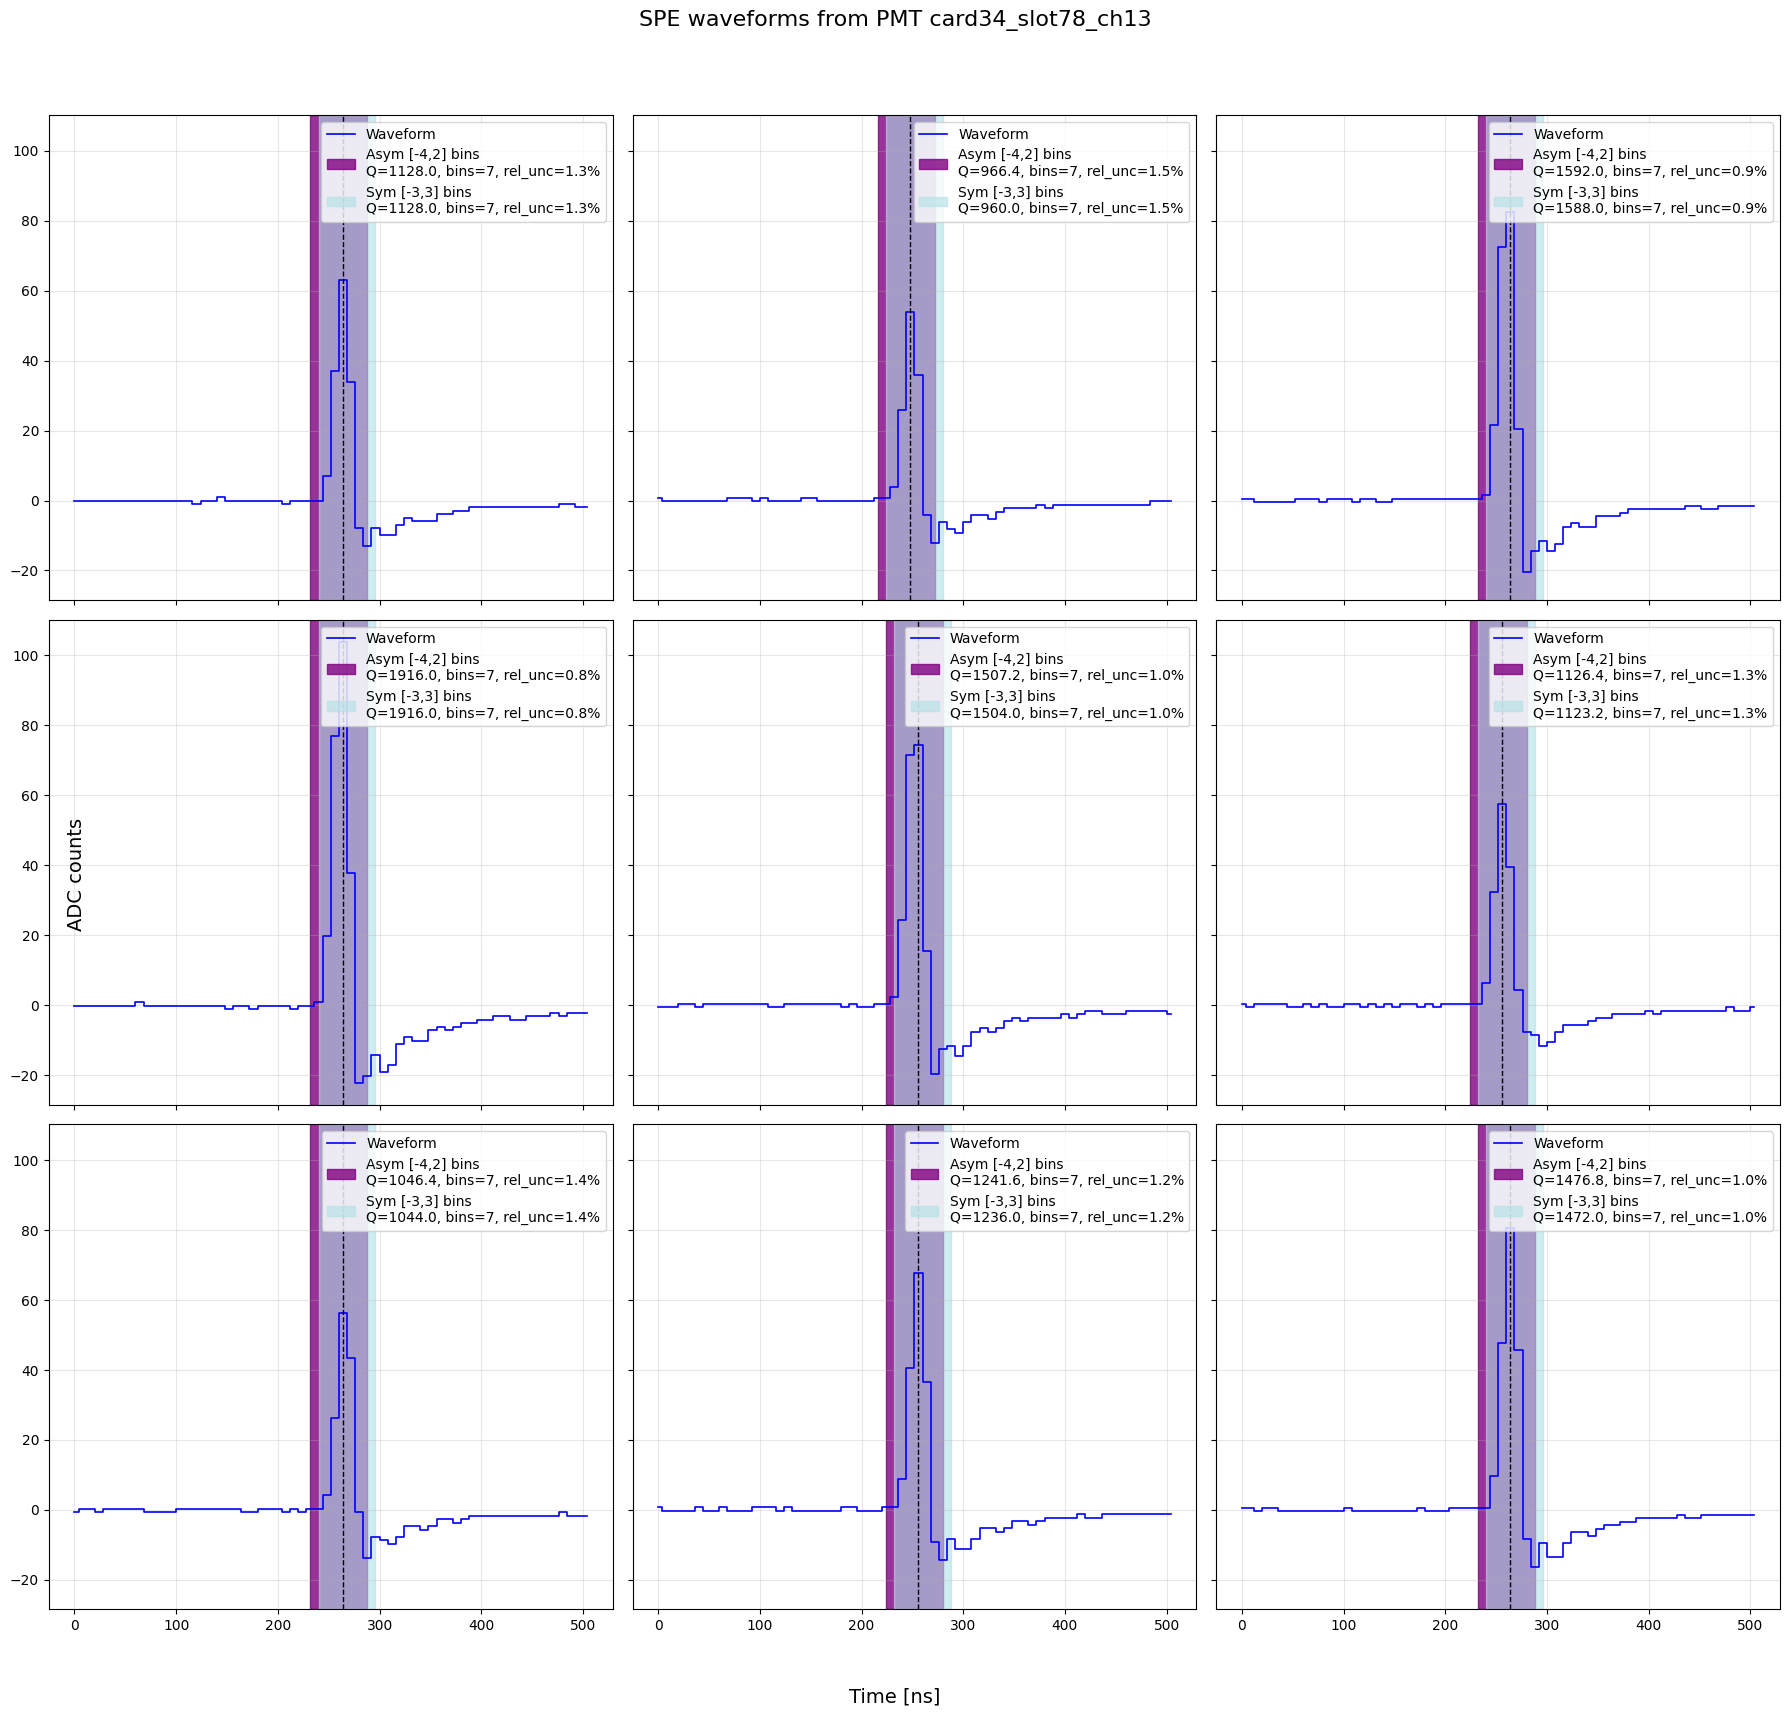

In [16]:
import numpy as np
import matplotlib.pyplot as plt

bin_width = 8.0  


signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
symmetric_window = (-3, +3)   

sigma_sample = np.std(control_waveforms[:, :20])  

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

# Choose different random waveforms every run
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Symmetric window
    start_sym = max(0, peak_idx + symmetric_window[0])
    end_sym   = min(len(wf), peak_idx + symmetric_window[1] + 1)
    bins_sym = end_sym - start_sym
    Q_sym = np.sum(np.clip(wf[start_sym:end_sym], 0, None)) * bin_width
    sigma_Q_sym = np.sqrt(bins_sym) * sigma_sample * bin_width
    rel_unc_sym = sigma_Q_sym / Q_sym * 100 if Q_sym > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_sym], time_axis[end_sym-1] + bin_width,
               alpha=0.6, color="powderblue", label=(
                   f"Sym [{symmetric_window[0]},{symmetric_window[1]}] bins\n"
                   f"Q={Q_sym:.1f}, bins={bins_sym}, rel_unc={rel_unc_sym:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

- Cada trigger → una waveform de 64 samples (cada sample = 8 ns).

- Cada sample está en ADC counts (digitalización de la señal analógica del PMT).

Queremos medir el gain de cada PMT, es decir:


$$
G = \frac{Q_{\text{1 p.e.}}}{e}
$$

donde $Q_{\text{1 p.e.}}$ es la carga promedio de un solo fotoelectrón y $e$ es la carga elemental.



Pero en tu DAQ, no tienes directamente Coulombs, sino ADC counts.

Lo que hacemos para relacionarlas: 

Cada waveform → se integra (suma de samples × ancho de bin) para obtener una carga total en ADC·ns.

Esto es equivalente a medir el área del pulso. Esa área es proporcional a la carga real colectada en el ánodo del PMT.

Luego, haces un histograma de todas esas cargas (de un LED run). Verás un pedestal (0 p.e.), un primer pico (1 p.e.), y a veces un segundo pico (2 p.e.) si tienes buena estadística.

In [87]:
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [97]:
card_id = 100
slot_id = 24
channel_id = 16

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [98]:
signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
control_npz = os.path.join(control_dir, pmt_label + ".npz")


pre_peak   = 4   # bins before max (for SPE)
post_peak  = 1   # bins after max (for SPE)
ped_window = 4   # symmetric window width (for pedestal)

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

def integrate_waveform_signal(wf, pre_peak=pre_peak, post_peak=post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

def integrate_waveform_control(wf, window=ped_window):
    peak_idx = np.argmax(wf)
    half_w = window // 2
    start = max(0, peak_idx - half_w)
    end   = min(len(wf), peak_idx + half_w)
    return np.sum(wf[start:end])

charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])
charges_control = np.array([integrate_waveform_control(wf) for wf in control_waveforms])



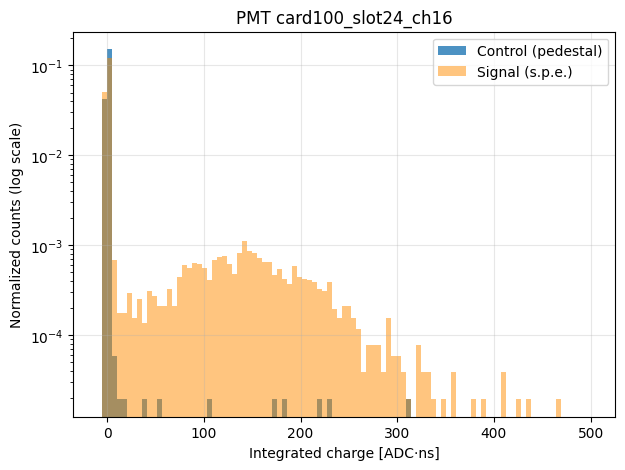

In [99]:
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_control, bins=bins, color = "#1f77b4", alpha=0.8, label="Control (pedestal)", density=True)
plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()

In [100]:
# NLL

def stable_nll(params, data):
    mu1, sigma1, mu2, sigma2, w = params
    if sigma1 <= 0 or sigma2 <= 0:    # sigma > 0, w in (0,1)
        return 1e300
    # clip w away from 0/1 for log stability
    w = float(np.clip(w, 1e-9, 1-1e-9))
    # logpdfs
    lp1 = norm.logpdf(data, loc=mu1, scale=sigma1)
    lp2 = norm.logpdf(data, loc=mu2, scale=sigma2)
    # log of mixture pdf: log( w*exp(lp1) + (1-w)*exp(lp2) ) = logsumexp( log(w)+lp1, log(1-w)+lp2 )
    a = np.log(w) + lp1
    b = np.log(1.0 - w) + lp2
    # use numpy logaddexp for stable log-sum-exp elementwise
    lpmix = np.logaddexp(a, b)
    # negative log-likelihood
    return -np.sum(lpmix)


#try multiple random starts

def fit_double_gauss_multistart(data, n_starts=12, verbose=True):
    best = None
    best_nll = np.inf

    # sensible heuristics from data
    p10, p30, p50, p70, p90 = np.percentile(data, [10,30,50,70,90])
    spe_candidates = data[(data>80) & (data<200)]
    mu2_guess = np.median(spe_candidates) if len(spe_candidates)>0 else p70

    # grid of initial guesses (small grid + some random perturbations)
    init_list = []
    mus1 = [0.0, p10, p30]
    mus2 = [mu2_guess, p70, p90]
    sigs = [3.0, 10.0, 20.0]
    ws = [0.1, 0.3, 0.5]

    for mu1 in mus1:
        for mu2 in mus2:
            for s1 in sigs:
                for s2 in sigs:
                    for w in ws:
                        init_list.append([mu1, s1, mu2, s2, w])
                        if len(init_list) >= n_starts:
                            break
                    if len(init_list) >= n_starts: break
                if len(init_list) >= n_starts: break
            if len(init_list) >= n_starts: break
        if len(init_list) >= n_starts: break

    # if still fewer than requested, add random inits
    rng = np.random.default_rng(12345)
    while len(init_list) < n_starts:
        mu1_r = float(rng.normal(loc=0.0, scale=5.0))
        mu2_r = float(rng.uniform(p50, p90+20))
        s1_r = float(rng.uniform(1.0, 15.0))
        s2_r = float(rng.uniform(5.0, 40.0))
        w_r  = float(rng.uniform(0.01, 0.9))
        init_list.append([mu1_r, s1_r, mu2_r, s2_r, w_r])

    bounds = [(-50, 50), (0.1, 100), ( -10, 500), (0.1, 200), (1e-6, 1-1e-6)]

    for i, p0 in enumerate(init_list):
        res = minimize(stable_nll, p0, args=(data,), method="L-BFGS-B", bounds=bounds,
                       options={'maxiter':1000})
        if not res.success and verbose:
            # keep trying, but print a short message
            pass
        if res.fun < best_nll:
            best_nll = res.fun
            best = res

    if best is None:
        raise RuntimeError("No successful fit found.")
    # reorder so mu1 < mu2 (pedestal = component with smaller mean)
    mu1f, s1f, mu2f, s2f, wf = best.x
    if mu1f > mu2f:
        # swap components
        mu1f, mu2f = mu2f, mu1f
        s1f, s2f = s2f, s1f
        wf = 1.0 - wf

    # attach diagnostics
    out = {
        'mu1': mu1f, 'sigma1': s1f, 'mu2': mu2f, 'sigma2': s2f, 'w': wf,
        'nll': best.fun, 'success': best.success, 'message': best.message, 'result_obj': best
    }
    if verbose:
        print("Best fit status:", out['success'], "-", out['message'])
        print(f"Negative log-likelihood: {out['nll']:.3f}")
    return out


# Run fit in data
fit_res = fit_double_gauss_multistart(charges_signal, n_starts=15, verbose=True)

mu1, sigma1, mu2, sigma2, w = fit_res['mu1'], fit_res['sigma1'], fit_res['mu2'], fit_res['sigma2'], fit_res['w']

print("\nFit final:")
print(f"mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.4f}")

Best fit status: True - b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Negative log-likelihood: 22162.172

Fit final:
mu1=0.674, sigma1=0.855, mu2=135.383, sigma2=81.873, w=0.8720


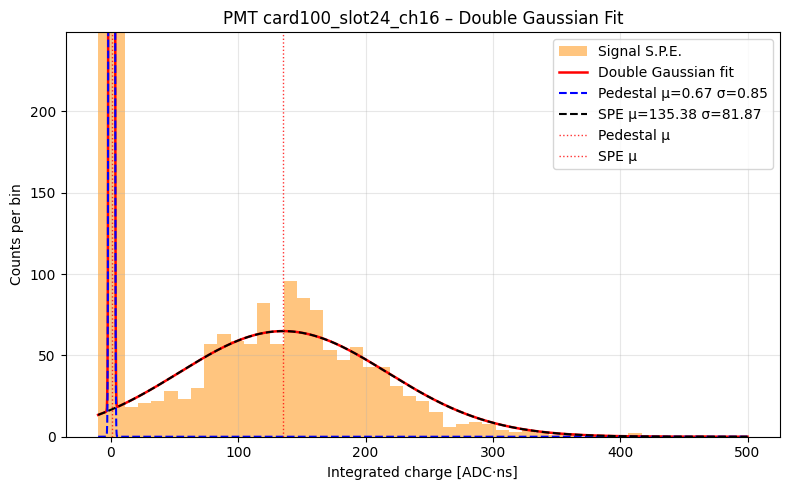

In [102]:
def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

plt.figure(figsize=(8,5))
bins = np.linspace(-10, 500, 50)

# Raw counts
counts, bins, _ = plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal S.P.E.", density=False)

bin_width = bins[1] - bins[0]
N = len(charges_signal)

x_vals = np.linspace(-10, 500, 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped   * N * bin_width
pdf_spe_counts   = pdf_spe   * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.2f} σ={sigma1:.2f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.2f} σ={sigma2:.2f}")

# Líneas verticales punteadas rojas para medias
plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8, label=f"Pedestal μ")
plt.axvline(mu2, color='red', linestyle=':', lw=1, alpha=0.8, label=f"SPE μ")

plt.ylim(0, np.max(counts)*0.05)   # limita el eje y para ver el SPE
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Counts per bin")
plt.title(f"PMT {pmt_label} – Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

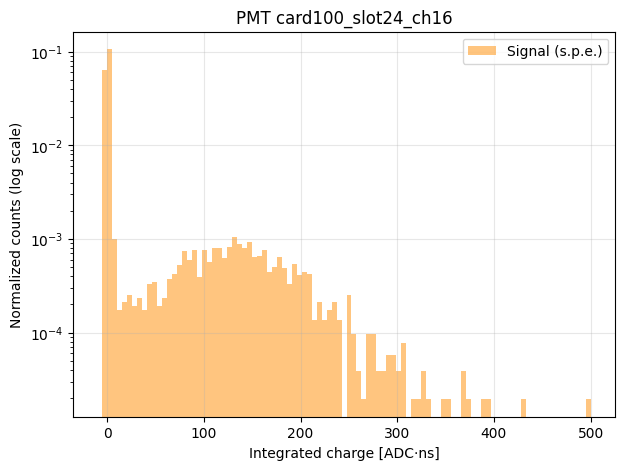

NameError: name 'err_mu1' is not defined

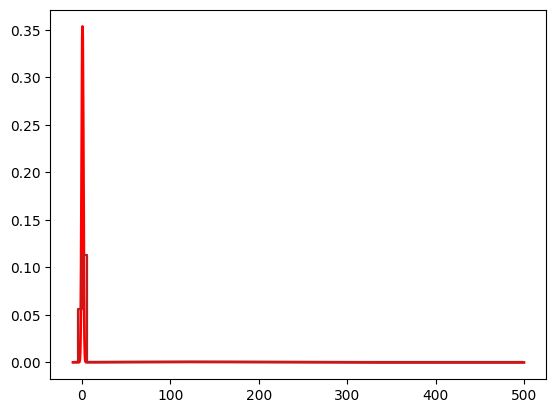

In [25]:
charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])

# --- Plot both distributions ---
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()


# === OVERLAY: modelo sobre tu histograma en log ===

# 1) Fit unbinned (línea suave)
x_vals = np.linspace(bins.min(), bins.max(), 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
plt.plot(x_vals, pdf_total, 'r-', lw=2, zorder=3, label="Double Gauss Fit (unbinned)")

# 2) Modelo binned (para que cuadre con las barras en log)
edges = bins
widths = np.diff(edges)

# densidad esperada por bin = ΔCDF / Δx
cdf1 = norm.cdf((edges - mu1)/sigma1)
cdf2 = norm.cdf((edges - mu2)/sigma2)
dens_binned_total = (w*(cdf1[1:] - cdf1[:-1]) + (1-w)*(cdf2[1:] - cdf2[:-1])) / widths
centers = 0.5*(edges[:-1] + edges[1:])

plt.step(centers, dens_binned_total, where='mid', lw=1.6, color='firebrick',
         zorder=3, label="Model (binned expectation)")

# Componentes (también en representación binned)
dens_ped = (w*(norm.cdf((edges[1:] - mu1)/sigma1) - norm.cdf((edges[:-1] - mu1)/sigma1))) / widths
dens_spe = ((1-w)*(norm.cdf((edges[1:] - mu2)/sigma2) - norm.cdf((edges[:-1] - mu2)/sigma2))) / widths

# Rescale del SPE SOLO para visibilidad (no afecta al fit)
scale_spe = 0.8 * np.max(dens_ped) / max(np.max(dens_spe), 1e-300)
plt.step(centers, dens_ped, where='mid', lw=1.3, ls='--', color='navy',
         zorder=3, label=f"Pedestal μ={mu1:.1f}±{err_mu1:.1f}")
plt.step(centers, dens_spe*scale_spe, where='mid', lw=1.3, ls='--', color='k',
         zorder=3, label=f"SPE μ={mu2:.1f}±{sigma2:.1f} (rescaled for vis)")

# (tu yscale, labels, grid, legend y título se mantienen como ya los tienes)


In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Directories ---
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

# --- Select PMT ---
card_id = 100
slot_id = 24
channel_id = 16
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
control_npz = os.path.join(control_dir, pmt_label + ".npz")

# --- Integration windows ---
pre_peak   = 4   # bins before max (SPE)
post_peak  = 2   # bins after max (SPE)
ped_window = 4   # symmetric window width (pedestal)

# --- Load waveforms ---
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

# --- Integration functions ---
def integrate_waveform_signal(wf, pre_peak=pre_peak, post_peak=post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

def integrate_waveform_control(wf, window=ped_window):
    peak_idx = np.argmax(wf)
    half_w = window // 2
    start = max(0, peak_idx - half_w)
    end   = min(len(wf), peak_idx + half_w)
    return np.sum(wf[start:end])

charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])
charges_control = np.array([integrate_waveform_control(wf) for wf in control_waveforms])

# --- Mode window finder with optional ADC range ---
def find_modal_window(charges, adc_range=None, bins=200, threshold_frac=0.2, min_width=20):
    charges = np.array(charges)
    if adc_range is not None:
        lo_cut, hi_cut = adc_range
        charges = charges[(charges > lo_cut) & (charges < hi_cut)]
    
    hist, edges = np.histogram(charges, bins=bins)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    
    max_bin = np.argmax(hist)
    mode_est = bin_centers[max_bin]
    
    threshold = threshold_frac * hist[max_bin]
    left = max_bin
    right = max_bin
    while left > 0 and hist[left] > threshold:
        left -= 1
    while right < len(hist)-1 and hist[right] > threshold:
        right += 1
    
    lo = max(bin_centers[left], adc_range[0] if adc_range else bin_centers[left])
    hi = min(bin_centers[right], adc_range[1] if adc_range else bin_centers[right])
    if hi - lo < min_width:
        hi = lo + min_width
    
    selected = charges[(charges > lo) & (charges < hi)]
    return mode_est, lo, hi, selected

# --- Unbinned Gaussian MLE fit ---
def fit_gaussian_unbinned(data):
    data = np.array(data)
    if len(data) < 10:
        return np.nan, np.nan, False
    
    def nll(params):
        mu, sigma = params
        if sigma <= 0:
            return np.inf
        return 0.5 * np.sum(((data - mu)/sigma)**2 + np.log(2*np.pi*sigma**2))
    
    mu0, sigma0 = np.mean(data), np.std(data)
    result = minimize(nll, x0=[mu0, sigma0], method="Nelder-Mead")
    
    if result.success:
        mu_fit, sigma_fit = result.x
        return mu_fit, sigma_fit, True
    else:
        return mu0, sigma0, False

# --- Fit pedestal ---
ped_mode, ped_lo, ped_hi, ped_sel = find_modal_window(charges_control, adc_range=(-50,50))
mu_ped, sigma_ped, ok_ped = fit_gaussian_unbinned(ped_sel)

# --- Fit SPE with fixed range [80,200] ---
spe_mode, spe_lo, spe_hi, spe_sel = find_modal_window(charges_signal, adc_range=(80,200))
mu_spe, sigma_spe, ok_spe = fit_gaussian_unbinned(spe_sel)

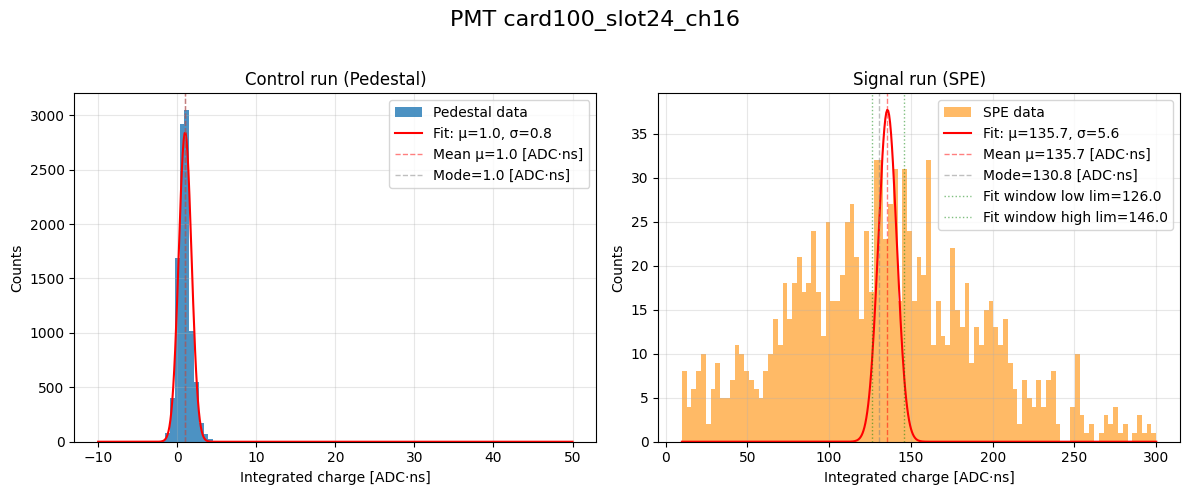

In [28]:

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Control (pedestal)
ax = axes[0]
bins_ped = np.linspace(-10, 50, 100)
hist_ped, edges_ped, _ = ax.hist(charges_control, bins=bins_ped, color = "#1f77b4", alpha=0.8, label="Pedestal data")
x_vals = np.linspace(-10, 50, 500)
if ok_ped:
    bin_width = edges_ped[1] - edges_ped[0]
    y_fit = (len(ped_sel) * bin_width) * (1/(np.sqrt(2*np.pi)*sigma_ped)) * np.exp(-0.5*((x_vals-mu_ped)/sigma_ped)**2)
    ax.plot(x_vals, y_fit, 'r-', lw=1.5, label=f"Fit: μ={mu_ped:.1f}, σ={sigma_ped:.1f}")
ax.axvline(mu_ped, color="red", ls="--", lw=1, alpha=0.5, label=f"Mean μ={mu_ped:.1f} [ADC·ns]")
ax.axvline(ped_mode, color="gray", ls="--", lw=1, alpha=0.5, label=f"Mode={ped_mode:.1f} [ADC·ns]")
ax.set_xlabel("Integrated charge [ADC·ns]")
ax.set_ylabel("Counts")
ax.set_title("Control run (Pedestal)")
ax.legend()
ax.grid(alpha=0.3)

# Signal (SPE)
ax = axes[1]
bins_spe = np.linspace(10, 300, 100)
hist_spe, edges_spe, _ = ax.hist(charges_signal, bins=bins_spe, color = "darkorange", alpha=0.6, label="SPE data")
x_vals = np.linspace(10, 300, 500)
if ok_spe:
    bin_width = edges_spe[1] - edges_spe[0]
    y_fit = (len(spe_sel) * bin_width) * (1/(np.sqrt(2*np.pi)*sigma_spe)) * np.exp(-0.5*((x_vals-mu_spe)/sigma_spe)**2)
    ax.plot(x_vals, y_fit, 'r-', lw=1.5, label=f"Fit: μ={mu_spe:.1f}, σ={sigma_spe:.1f}")
ax.axvline(mu_spe, color="red", ls="--", lw=1, alpha=0.5, label=f"Mean μ={mu_spe:.1f} [ADC·ns]")
ax.axvline(spe_mode, color="gray", ls="--", lw=1, alpha=0.5, label=f"Mode={spe_mode:.1f} [ADC·ns]")
ax.axvline(spe_lo, color="green", ls=":", lw=1, alpha=0.5, label=f"Fit window low lim={spe_lo:.1f}")
ax.axvline(spe_hi, color="green", ls=":", lw=1, alpha=0.5, label=f"Fit window high lim={spe_hi:.1f}")
ax.set_xlabel("Integrated charge [ADC·ns]")
ax.set_ylabel("Counts")
ax.set_title("Signal run (SPE)")
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle(f"PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

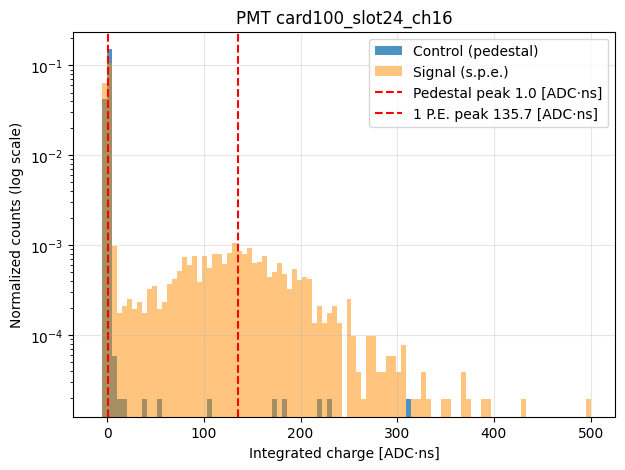

In [29]:

# --- Plot both distributions ---
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_control, bins=bins, color = "#1f77b4", alpha=0.8, label="Control (pedestal)", density=True)
plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.axvline(mu_ped, color="red", ls="--", lw=1.5, alpha=1, label=f"Pedestal peak {mu_ped:.1f} [ADC·ns]")
plt.axvline(mu_spe, color="red", ls="--", lw=1.5, alpha=1, label=f"1 P.E. peak {mu_spe:.1f} [ADC·ns]")

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()
